In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [3]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic={'Sale':1,'No Sale':0}

# convert categorical output variable to binary
df['ResultOfTour']=df['ResultOfTour'].replace(dic)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14445 entries, 146456 to 381090
Data columns (total 11 columns):
Age                           14445 non-null int64
AgentLine                     14445 non-null object
BookingWindow                 14445 non-null object
FirstGenVsOwner               14445 non-null object
HHIncomeRanges                14445 non-null object
Homeowner                     14445 non-null object
InState                       14445 non-null object
Programs (Budget)             14445 non-null object
relationStatus                14445 non-null object
ResultOfTour                  14445 non-null int64
NetVolumePlusNonGoodVolume    14445 non-null float64
dtypes: float64(1), int64(2), object(8)
memory usage: 1.3+ MB
None


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dfX = df.drop(['ResultOfTour',  'AgentLine', 'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=['BookingWindow', 'FirstGenVsOwner',
       'HHIncomeRanges', 'Homeowner', 'InState', 'Programs (Budget)',
       'relationStatus'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])
       

X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)




dfX1 = X_train
dfY1 = y_train
 



print(dfX1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11556 entries, 371823 to 347592
Data columns (total 35 columns):
Age                                            11556 non-null float64
BookingWindow_Inside 2 Days                    11556 non-null uint8
BookingWindow_Inside 90 days                   11556 non-null uint8
BookingWindow_Inside Half Year                 11556 non-null uint8
BookingWindow_Inside Month                     11556 non-null uint8
BookingWindow_Inside Week                      11556 non-null uint8
BookingWindow_Inside Year                      11556 non-null uint8
BookingWindow_Over a Year                      11556 non-null uint8
FirstGenVsOwner_1st Gen                        11556 non-null uint8
FirstGenVsOwner_Owner                          11556 non-null uint8
HHIncomeRanges_150k to 199k                    11556 non-null uint8
HHIncomeRanges_200k to 349k                    11556 non-null uint8
HHIncomeRanges_350k to 500k                    11556 non-null uint8

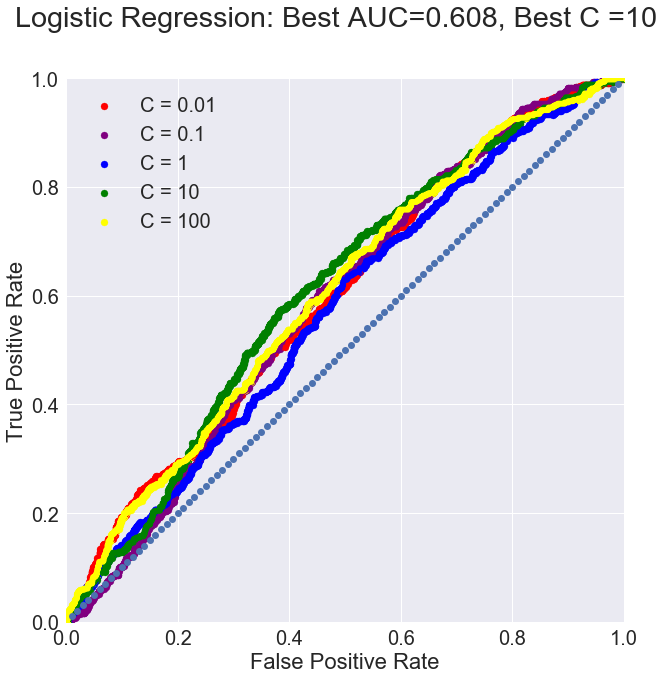

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

bestC = 0
bestAUCC = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,100]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    lr = LogisticRegression(C=Cs[i])
    lr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCC:
        bestC=Cs[i]
        bestAUCC=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='C = '+str(Cs[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('Logistic Regression: Best AUC='+str(round(bestAUCC,3))+', Best C ='+str(bestC))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV
parameters={
'C': [0.01, 0.1, 1,10,100],
}

clf = GridSearchCV(estimator=LogisticRegression(),param_grid=parameters,n_jobs=1,verbose=0,cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc' )
clf.fit(dfX1,dfY1)
print(clf.best_params_)
print(clf.best_score_)

{'C': 100}
0.5956819955660756


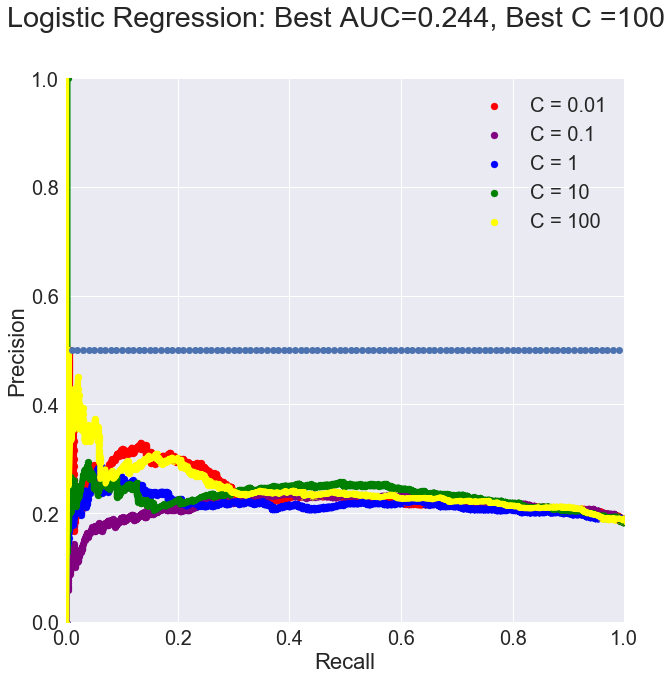

In [7]:
# from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

bestC1 = 0
bestAUCC1 = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,100]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precision')

for train, test in kf.split(dfX1,dfY1):
    lr = LogisticRegression(C=Cs[i])
    lr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    p, r, _ = precision_recall_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(r,p)
    if auc>bestAUCC1:
        bestC1=Cs[i]
        bestAUCC1=auc
    i += 1 
    plt.scatter(x=r, y=p, c = colors[i-1],label='C = '+str(Cs[i-1]))
    plt.plot(r,p, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('Logistic Regression: Best AUC='+str(round(bestAUCC1,3))+', Best C ='+str(bestC1))
x1 = np.arange(1,100)/100
y1 = np.repeat(0.5,99)
plt.plot(x1,y1,'o')
plt.show()

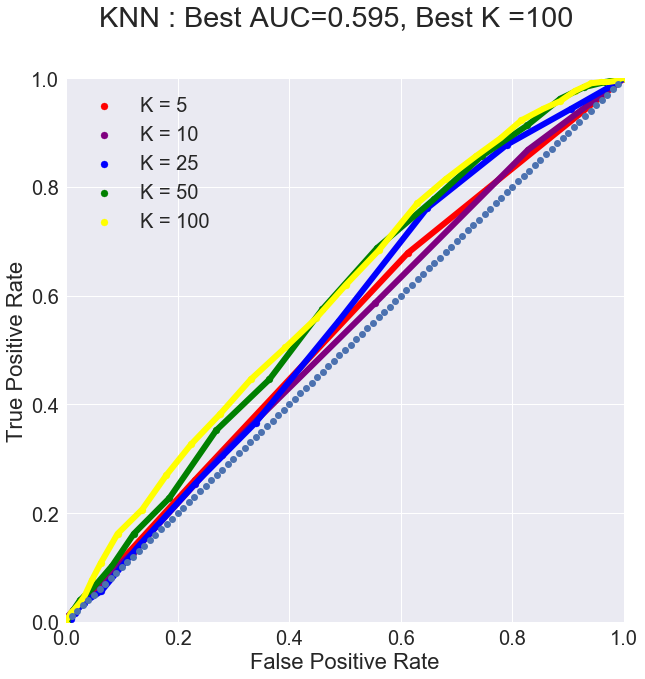

In [8]:
from sklearn.neighbors import KNeighborsClassifier


bestK = 0
bestAUCK = 0
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ks = [5,10,25,50,100]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    knn = KNeighborsClassifier(Ks[i])
    knn.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = knn.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCK:
        bestK=Ks[i]
        bestAUCK=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='K = '+str(Ks[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('KNN : Best AUC='+str(round(bestAUCK,3))+', Best K ='+str(bestK))
plt.plot(x,y,'o')
plt.show()


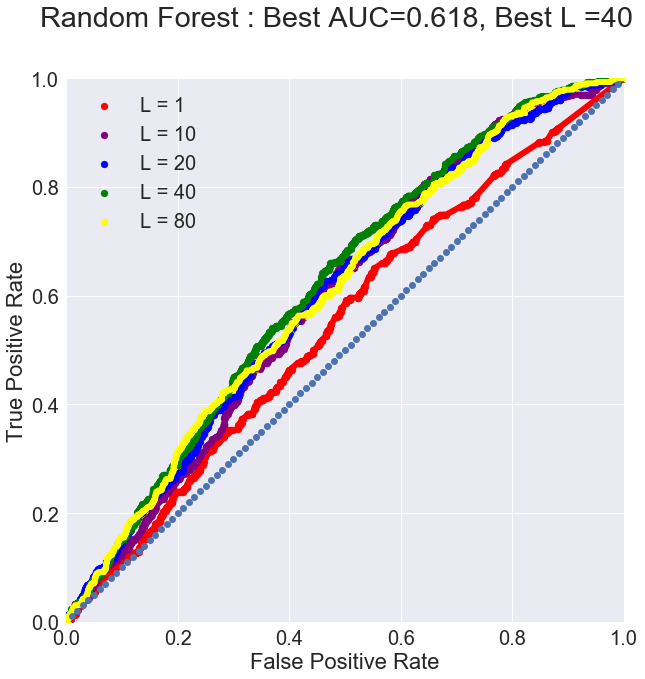

In [9]:
from sklearn.ensemble import RandomForestClassifier

bestL = 0
bestAUCL = 0
bestFeatureImportances= []
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ls = [1,10,20,40,80]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    rfr = RandomForestClassifier(n_estimators=100,min_samples_leaf=Ls[i], random_state=42)
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCL:
        bestL=Ls[i]
        bestAUCL=auc
        bestFeatureImportances = rfr.feature_importances_
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='L = '+str(Ls[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('Random Forest : Best AUC='+str(round(bestAUCL,3))+', Best L ='+str(bestL))
plt.plot(x,y,'o')
plt.show()

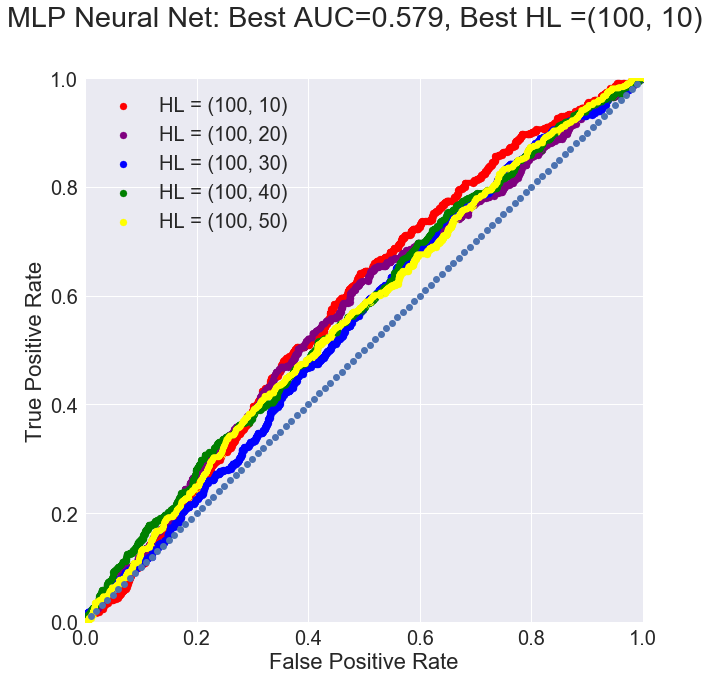

In [10]:
from sklearn.neural_network import MLPClassifier

bestHL = 0
bestAUCHL = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
HLs = [(100,10), (100,20), (100,30), (100,40), (100,50)]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    lr = MLPClassifier(hidden_layer_sizes=HLs[i])
    lr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCHL:
        bestHL=HLs[i]
        bestAUCHL=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='HL = '+str(HLs[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('MLP Neural Net: Best AUC='+str(round(bestAUCHL,3))+', Best HL ='+str(bestHL))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

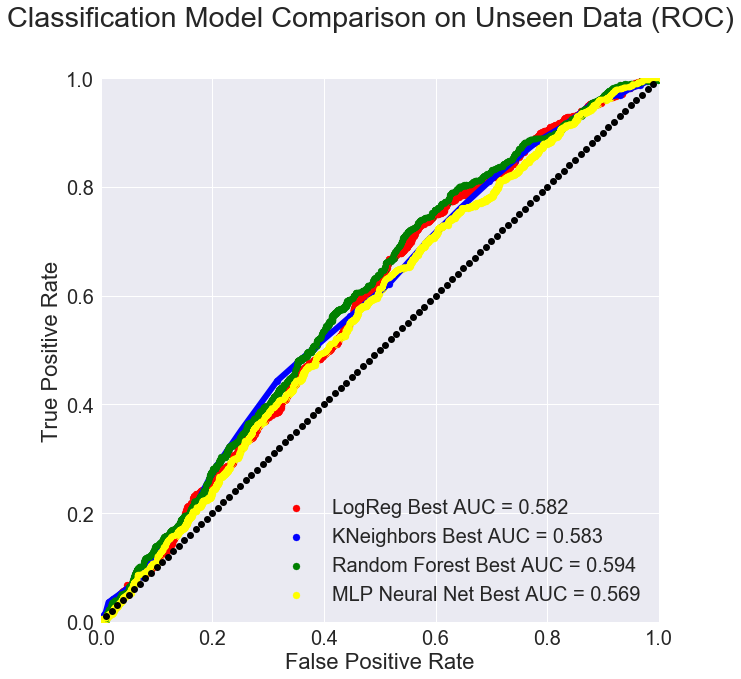

In [11]:
#logistic regregression best model 
lr = LogisticRegression(C=bestC)
lr.fit(dfX1,dfY1)
preds = lr.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=fpr, y=tpr, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Red',linewidth=6.0)


#knn best model 
knn = KNeighborsClassifier(bestK)
knn.fit(dfX1,dfY1)
preds = knn.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Blue', label= 'KNeighbors Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Blue',linewidth=6.0)

#random forest best model 
clf = RandomForestClassifier(n_estimators=100,min_samples_leaf =bestL,random_state=42)
clf.fit(dfX1,dfY1)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Green',linewidth=6.0)

# Neural Net MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=bestHL)
clf.fit(dfX1,dfY1)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Yellow', label= 'MLP Neural Net Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Yellow',linewidth=6.0)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot(x,y,'o', color='Black')
plt.suptitle('Classification Model Comparison on Unseen Data (ROC)')
plt.show()

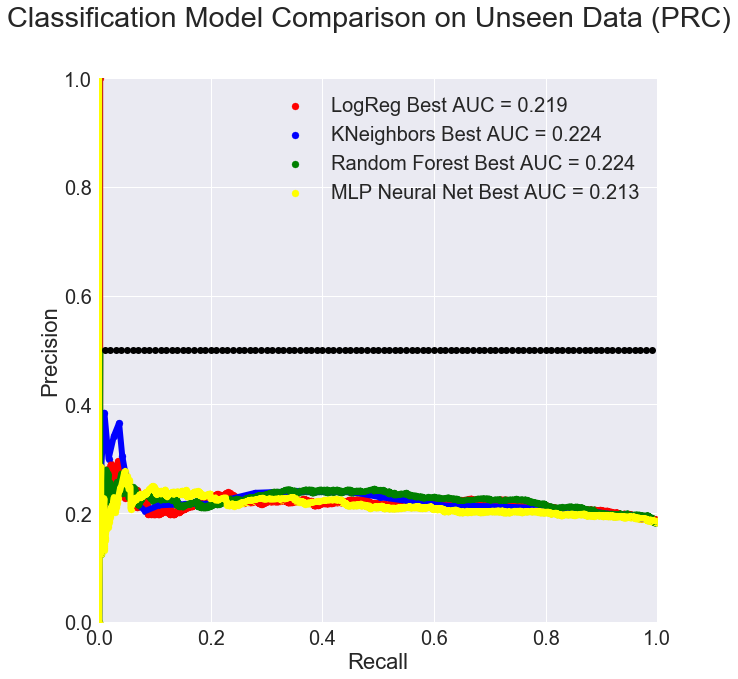

In [12]:
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#logistic regregression best model 
lr = LogisticRegression(C=bestC)
lr.fit(dfX1,dfY1)
preds = lr.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=r, y=p, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Red',linewidth=6.0)


#knn best model 
knn = KNeighborsClassifier(bestK)
knn.fit(dfX1,dfY1)
preds = knn.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Blue', label= 'KNeighbors Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Blue',linewidth=6.0)

#random forest best model 
clf = RandomForestClassifier(n_estimators=1000,min_samples_leaf =bestL,random_state=42)
clf.fit(dfX1,dfY1)
preds = clf.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Green',linewidth=6.0)

# Neural Net MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=bestHL)
clf.fit(dfX1,dfY1)
preds = clf.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Yellow', label= 'MLP Neural Net Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Yellow',linewidth=6.0)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.plot(x1,y1,'o', color='Black')
plt.suptitle('Classification Model Comparison on Unseen Data (PRC)')
plt.show()